# NumberOfTrips は正規分布に近づけても、学習度合いがあまり変わらなかったため、そのまま
メモ：この特徴量はカテゴリとしても扱える。訓練テストどちらも数値が共通しているから。

In [1]:
import os
os.chdir('../../')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scr.util import *

In [44]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.pipeline import Pipeline

In [47]:
df_train = pd.read_csv('data/null_survey/train_age_income_ok.csv')
df_test = pd.read_csv('data/null_survey/test_age_income_ok.csv')

In [21]:
df_train.isna().sum()

id                          0
Age                         0
TypeofContact               0
CityTier                    0
DurationOfPitch           121
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups           0
ProductPitched              0
PreferredPropertyStar       0
NumberOfTrips              22
Passport                    0
PitchSatisfactionScore      0
Designation                 0
MonthlyIncome               0
ProdTaken                   0
Marry                       0
Car                         0
Child                       0
AgeGroup                    0
dtype: int64

In [22]:
df_test.isna().sum()

id                          0
Age                         0
TypeofContact               0
CityTier                    0
DurationOfPitch           131
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups           0
ProductPitched              0
PreferredPropertyStar       0
NumberOfTrips              42
Passport                    0
PitchSatisfactionScore      0
Designation                 0
MonthlyIncome               0
Marry                       0
Car                         0
Child                       0
AgeGroup                    0
dtype: int64

<Axes: >

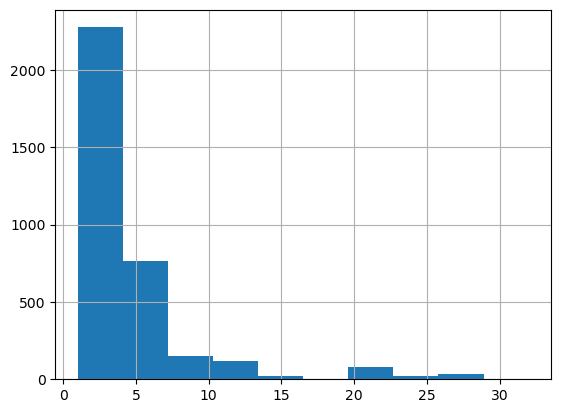

In [48]:
df_train['NumberOfTrips'].hist()

<Axes: >

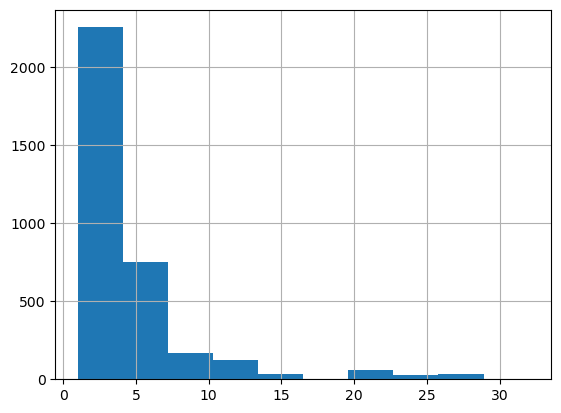

In [49]:
df_test['NumberOfTrips'].hist()

In [25]:
df_train['NumberOfTrips'].value_counts()

NumberOfTrips
2.0     1009
3.0      699
5.0      436
1.0      366
7.0      219
4.0      201
8.0      149
12.0     121
6.0      109
20.0      79
28.0      37
24.0      21
16.0      19
32.0       2
Name: count, dtype: int64

In [26]:
df_test['NumberOfTrips'].value_counts()

NumberOfTrips
2.0     953
3.0     762
5.0     400
1.0     330
7.0     226
4.0     208
8.0     165
6.0     125
12.0    124
20.0     62
16.0     31
28.0     31
24.0     26
32.0      4
Name: count, dtype: int64

In [27]:
# NumberOfTripを正規分布に近づける。

# df_train['NumberOfTrips'] = np.log1p(df_train['NumberOfTrips'])
# df_test['NumberOfTrips'] = np.log1p(df_test['NumberOfTrips'])

<Axes: >

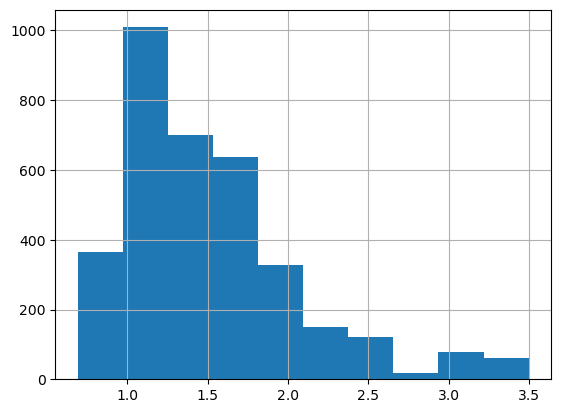

In [28]:
# df_train['NumberOfTrips'].hist()

<Axes: >

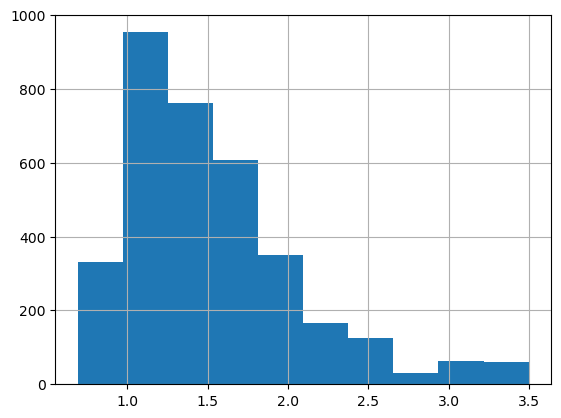

In [29]:
# df_test['NumberOfTrips'].hist()

In [30]:
# df_train['NumberOfTrips'].isna().sum()

22

In [31]:
# df_test['NumberOfTrips'].isna().sum()

42

# 今回調査する欠損値：Age, DurationOfPitch, *NumberOfTrips*, MonthlyIncome

# NumberOfTrips

In [50]:
df_all = pd.concat([df_train, df_test], axis=0)

In [51]:
df_all.columns

Index(['id', 'Age', 'TypeofContact', 'CityTier', 'DurationOfPitch',
       'Occupation', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'ProdTaken',
       'Marry', 'Car', 'Child', 'AgeGroup'],
      dtype='object')

In [52]:
# NumberOfTrips を予測するための特徴量を選択
predict_trips_features = ['Age', 'TypeofContact','CityTier','Occupation','Gender','NumberOfPersonVisiting',
                        'NumberOfFollowups','ProductPitched','PreferredPropertyStar','PitchSatisfactionScore', 'Passport','Designation','MonthlyIncome' ,'Marry', 'Car','Child', 'AgeGroup']

# 主キー用idを取得
id_train = df_train.loc[df_train['NumberOfTrips'].isna()].index
id_test = df_test.loc[df_test['NumberOfTrips'].isna()].index

# 目的変数をNumberOfTripsとする
X_train_predict_trips = df_all.loc[~(df_all['NumberOfTrips'].isna()), predict_trips_features]
X_test_predict_trips = df_all.loc[df_all['NumberOfTrips'].isna(), predict_trips_features]
y_train_predict_trips = df_all.loc[~(df_all['NumberOfTrips'].isna()), 'NumberOfTrips']
y_test_predict_trips = None

In [53]:
X_train_predict_trips, X_test_predict_trips = mapping_first_category_plus_agegroup(X_train_predict_trips, X_test_predict_trips)
X_train_predict_trips, X_test_predict_trips = feature_to_int(X_train_predict_trips, X_test_predict_trips)

In [54]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_list = list(kf.split(X_train_predict_trips, y_train_predict_trips))

def train_catboost(X, y, cv, params: dict = None):
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records, ))
    for i, (tr_idx, va_idx) in enumerate(cv):
        tr_x, va_x = X.iloc[tr_idx], X.iloc[va_idx]
        tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]
        model = cb.CatBoostRegressor(**params)
        model.fit(tr_x, tr_y, eval_set=(va_x, va_y), use_best_model=True, verbose=100)
        oof_pred[va_idx] = model.predict(va_x)
        models.append(model)
    return oof_pred, models

params = {
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'iterations': 10000,
    'learning_rate': 0.005,
    'depth': 5,
    'l2_leaf_reg': 5,    # 3 ~ 10
    'verbose': 200,
    'random_seed': 42,
}

oof, models = train_catboost(X_train_predict_trips, y_train_predict_trips, cv_list, params)

0:	learn: 4.6641336	test: 4.2857145	best: 4.2857145 (0)	total: 1.78ms	remaining: 17.8s
100:	learn: 4.6218504	test: 4.2594017	best: 4.2594017 (100)	total: 118ms	remaining: 11.6s
200:	learn: 4.5955671	test: 4.2476385	best: 4.2476385 (200)	total: 230ms	remaining: 11.2s
300:	learn: 4.5746627	test: 4.2428500	best: 4.2428500 (300)	total: 341ms	remaining: 11s
400:	learn: 4.5577956	test: 4.2390812	best: 4.2390812 (400)	total: 453ms	remaining: 10.8s
500:	learn: 4.5434084	test: 4.2382216	best: 4.2379781 (464)	total: 587ms	remaining: 11.1s
600:	learn: 4.5307360	test: 4.2383964	best: 4.2379702 (564)	total: 746ms	remaining: 11.7s
700:	learn: 4.5196193	test: 4.2388672	best: 4.2379702 (564)	total: 875ms	remaining: 11.6s
800:	learn: 4.5081962	test: 4.2393954	best: 4.2379702 (564)	total: 995ms	remaining: 11.4s
900:	learn: 4.4977702	test: 4.2410307	best: 4.2379702 (564)	total: 1.1s	remaining: 11.2s
1000:	learn: 4.4885243	test: 4.2427049	best: 4.2379702 (564)	total: 1.22s	remaining: 11s
1100:	learn: 4.47

In [55]:
y_test_predict_trips = np.zeros(len(X_test_predict_trips))

# アンサンブル
for model in models:
    y_test_predict_trips += model.predict(X_test_predict_trips) / len(models)

y_test_predict_trips = pd.DataFrame({
    'NumberOfTrips': y_test_predict_trips
})

In [56]:
# 訓練データとテストデータに分割する
predicted_train_trips = y_test_predict_trips.iloc[:len(id_train), 0]
predicted_test_trips = y_test_predict_trips.iloc[len(id_train): , 0]

# id(主キー)を与える。
predicted_train_trips.index = id_train
predicted_test_trips.index = id_test

In [58]:
df_train[290:300]

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,...,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,ProdTaken,Marry,Car,Child,AgeGroup
290,290,57,Company Invited,2,360.0,Large Business,female,3.0,4.0,Standard,...,5.0,0,2,Senior Manager,13.172554,0,Divorced,Has Car,2_child,50s
291,291,38,Company Invited,2,840.0,Salaried,female,3.0,4.0,Standard,...,2.0,0,2,Senior Manager,12.835044,0,Single,Has Car,2_child,30s
292,292,46,Self Enquiry,2,480.0,Small Business,male,3.0,4.0,Deluxe,...,2.0,0,2,Manager,12.787005,0,Single,No Car,2_child,40s
293,293,42,Self Enquiry,2,720.0,Small Business,male,3.0,4.0,Standard,...,NaN,0,1,Senior Manager,13.090503,1,Married,Has Car,2_child,40s
294,294,41,Self Enquiry,2,780.0,Salaried,male,3.0,4.0,King,...,2.0,0,1,Senior Manager,12.939656,0,Married,Has Car,2_child,40s
295,295,47,Self Enquiry,2,360.0,Salaried,male,3.0,4.0,Deluxe,...,NaN,0,2,AVP,13.053851,0,Single,Has Car,2_child,40s
296,296,26,Self Enquiry,2,780.0,Small Business,female,3.0,4.0,Deluxe,...,12.0,0,2,Manager,12.765691,0,Single,No Car,2_child,20s
297,297,54,Self Enquiry,2,960.0,Small Business,male,3.0,4.0,Standard,...,20.0,0,2,Senior Manager,12.860586,0,Single,Has Car,2_child,50s
298,298,30,Self Enquiry,2,840.0,Salaried,male,3.0,4.0,Standard,...,20.0,0,2,Senior Manager,12.995032,0,Married,No Car,2_child,30s
299,299,40,Self Enquiry,2,1860.0,Small Business,male,3.0,4.0,Deluxe,...,2.0,0,1,Manager,12.644331,0,Divorced,No Car,2_child,40s


In [60]:
df_test[1420:1430]

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,Marry,Car,Child,AgeGroup
1420,4909,57,Self Enquiry,2,1080.0,Salaried,male,3.0,4.0,King,3.0,NaN,0,1,VP,13.260787,Single,Has Car,2_child,50s
1421,4910,41,Company Invited,2,540.0,Salaried,female,3.0,4.0,King,3.0,NaN,0,2,VP,13.247455,Married,Has Car,2_child,40s
1422,4911,24,Company Invited,2,900.0,Small Business,female,2.0,3.0,Basic,3.0,2.0,0,4,Executive,12.496972,Married,Has Car,1_child,20s
1423,4912,29,Company Invited,2,1020.0,Small Business,female,1.0,3.0,Deluxe,3.0,4.0,0,4,Manager,12.676079,Married,Has Car,0_child,20s
1424,4913,34,Self Enquiry,2,900.0,Small Business,male,1.0,3.0,Deluxe,3.0,1.0,0,3,Manager,12.611541,Married,Has Car,0_child,30s
1425,4914,37,Company Invited,3,420.0,Small Business,female,1.0,3.0,Basic,3.0,3.0,0,4,Executive,12.454946,Single,Has Car,0_child,30s
1426,4915,41,Self Enquiry,2,600.0,Salaried,male,1.0,3.0,Deluxe,3.0,16.0,0,4,Manager,12.599722,Married,No Car,0_child,40s
1427,4916,54,Company Invited,2,960.0,Salaried,male,2.0,3.0,Standard,3.0,3.0,0,3,Senior Manager,13.029921,Married,No Car,1_child,50s
1428,4917,56,Self Enquiry,2,780.0,Salaried,male,1.0,3.0,Standard,3.0,5.0,0,4,Senior Manager,12.973193,Married,No Car,0_child,50s
1429,4918,28,Company Invited,2,960.0,Small Business,male,2.0,3.0,Deluxe,3.0,1.0,1,3,Manager,12.722456,Married,No Car,1_child,20s


In [61]:
# 欠損値を予測値で補完する
df_train.loc[df_train['NumberOfTrips'].isna(), 'NumberOfTrips'] = round(predicted_train_trips)
df_test.loc[df_test['NumberOfTrips'].isna(), 'NumberOfTrips'] = round(predicted_test_trips)

In [62]:
df_train[290:300]

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,...,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,ProdTaken,Marry,Car,Child,AgeGroup
290,290,57,Company Invited,2,360.0,Large Business,female,3.0,4.0,Standard,...,5.0,0,2,Senior Manager,13.172554,0,Divorced,Has Car,2_child,50s
291,291,38,Company Invited,2,840.0,Salaried,female,3.0,4.0,Standard,...,2.0,0,2,Senior Manager,12.835044,0,Single,Has Car,2_child,30s
292,292,46,Self Enquiry,2,480.0,Small Business,male,3.0,4.0,Deluxe,...,2.0,0,2,Manager,12.787005,0,Single,No Car,2_child,40s
293,293,42,Self Enquiry,2,720.0,Small Business,male,3.0,4.0,Standard,...,5.0,0,1,Senior Manager,13.090503,1,Married,Has Car,2_child,40s
294,294,41,Self Enquiry,2,780.0,Salaried,male,3.0,4.0,King,...,2.0,0,1,Senior Manager,12.939656,0,Married,Has Car,2_child,40s
295,295,47,Self Enquiry,2,360.0,Salaried,male,3.0,4.0,Deluxe,...,6.0,0,2,AVP,13.053851,0,Single,Has Car,2_child,40s
296,296,26,Self Enquiry,2,780.0,Small Business,female,3.0,4.0,Deluxe,...,12.0,0,2,Manager,12.765691,0,Single,No Car,2_child,20s
297,297,54,Self Enquiry,2,960.0,Small Business,male,3.0,4.0,Standard,...,20.0,0,2,Senior Manager,12.860586,0,Single,Has Car,2_child,50s
298,298,30,Self Enquiry,2,840.0,Salaried,male,3.0,4.0,Standard,...,20.0,0,2,Senior Manager,12.995032,0,Married,No Car,2_child,30s
299,299,40,Self Enquiry,2,1860.0,Small Business,male,3.0,4.0,Deluxe,...,2.0,0,1,Manager,12.644331,0,Divorced,No Car,2_child,40s


In [63]:
df_test[1420:1430]

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,Marry,Car,Child,AgeGroup
1420,4909,57,Self Enquiry,2,1080.0,Salaried,male,3.0,4.0,King,3.0,6.0,0,1,VP,13.260787,Single,Has Car,2_child,50s
1421,4910,41,Company Invited,2,540.0,Salaried,female,3.0,4.0,King,3.0,5.0,0,2,VP,13.247455,Married,Has Car,2_child,40s
1422,4911,24,Company Invited,2,900.0,Small Business,female,2.0,3.0,Basic,3.0,2.0,0,4,Executive,12.496972,Married,Has Car,1_child,20s
1423,4912,29,Company Invited,2,1020.0,Small Business,female,1.0,3.0,Deluxe,3.0,4.0,0,4,Manager,12.676079,Married,Has Car,0_child,20s
1424,4913,34,Self Enquiry,2,900.0,Small Business,male,1.0,3.0,Deluxe,3.0,1.0,0,3,Manager,12.611541,Married,Has Car,0_child,30s
1425,4914,37,Company Invited,3,420.0,Small Business,female,1.0,3.0,Basic,3.0,3.0,0,4,Executive,12.454946,Single,Has Car,0_child,30s
1426,4915,41,Self Enquiry,2,600.0,Salaried,male,1.0,3.0,Deluxe,3.0,16.0,0,4,Manager,12.599722,Married,No Car,0_child,40s
1427,4916,54,Company Invited,2,960.0,Salaried,male,2.0,3.0,Standard,3.0,3.0,0,3,Senior Manager,13.029921,Married,No Car,1_child,50s
1428,4917,56,Self Enquiry,2,780.0,Salaried,male,1.0,3.0,Standard,3.0,5.0,0,4,Senior Manager,12.973193,Married,No Car,0_child,50s
1429,4918,28,Company Invited,2,960.0,Small Business,male,2.0,3.0,Deluxe,3.0,1.0,1,3,Manager,12.722456,Married,No Car,1_child,20s


In [64]:
df_train.isna().sum()

id                          0
Age                         0
TypeofContact               0
CityTier                    0
DurationOfPitch           121
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups           0
ProductPitched              0
PreferredPropertyStar       0
NumberOfTrips               0
Passport                    0
PitchSatisfactionScore      0
Designation                 0
MonthlyIncome               0
ProdTaken                   0
Marry                       0
Car                         0
Child                       0
AgeGroup                    0
dtype: int64

In [65]:
df_test.isna().sum()

id                          0
Age                         0
TypeofContact               0
CityTier                    0
DurationOfPitch           131
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups           0
ProductPitched              0
PreferredPropertyStar       0
NumberOfTrips               0
Passport                    0
PitchSatisfactionScore      0
Designation                 0
MonthlyIncome               0
Marry                       0
Car                         0
Child                       0
AgeGroup                    0
dtype: int64

In [66]:
df_train.to_csv('data/null_survey/train_age_income_trips_ok.csv', index=False)
df_test.to_csv('data/null_survey/test_age_income_trips_ok.csv', index=False)